In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('../../utils/')
import biotite_utils
import dataset_utils
from  biotite.sequence import ProteinSequence

def count_amino_acid_types(dataset):
    binding_amino_acids = {'ALA': 0, 'ARG': 0, 'ASN': 0, 'ASP': 0, 'CYS': 0, 'GLN': 0, 'GLU': 0, 'GLY': 0, 'HIS': 0, 'ILE': 0, 'LEU': 0, 'LYS': 0, 'MET': 0, 'PHE': 0, 'PRO': 0, 'SER': 0, 'THR': 0, 'TRP': 0, 'TYR': 0, 'VAL': 0}
    nonbinding_amino_acids = {'ALA': 0, 'ARG': 0, 'ASN': 0, 'ASP': 0, 'CYS': 0, 'GLN': 0, 'GLU': 0, 'GLY': 0, 'HIS': 0, 'ILE': 0, 'LEU': 0, 'LYS': 0, 'MET': 0, 'PHE': 0, 'PRO': 0, 'SER': 0, 'THR': 0, 'TRP': 0, 'TYR': 0, 'VAL': 0}
    
    for id, binding_residues in dataset.items():
        if id == '8j1kA': continue # skip 8j1kA, it throws some weird error I don't want to debug

        # print(f'Processing {id} ...')
        
        protein = biotite_utils.load_structure(id)
        chain_id = id[4:]
        protein_structure = biotite_utils.get_protein_backbone(protein, chain_id)
        
        for residue in protein_structure:
            if residue.res_id in binding_residues:
                binding_amino_acids[residue.res_name] += 1
            else:
                nonbinding_amino_acids[residue.res_name] += 1
    return binding_amino_acids, nonbinding_amino_acids
   

In [3]:
DATASET = 'rigid-dataset'
DATASET_PATH = f'../../../datasets/{DATASET}'
rigid_ids = dataset_utils.get_annotations(DATASET_PATH)
rigid_binding_amino_acids, rigid_nonbinding_amino_acids = count_amino_acid_types(rigid_ids)

DATASET = 'cryptobench-dataset'
DATASET_PATH = f'../../../datasets/{DATASET}'
cryptobench_ids = dataset_utils.get_annotations(DATASET_PATH)
cryptobench_binding_amino_acids, cryptobench_nonbinding_amino_acids = count_amino_acid_types(cryptobench_ids)


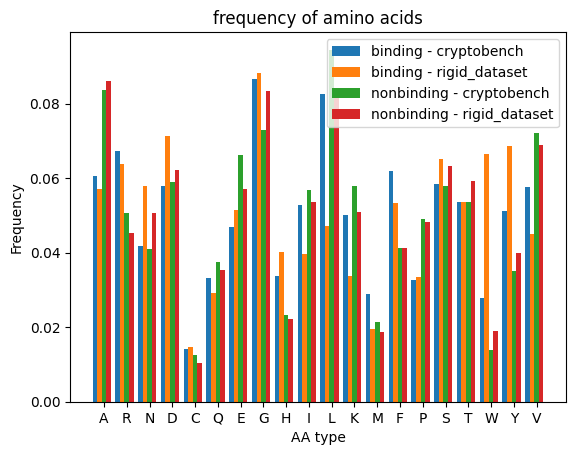

In [4]:
def normalize(original_list):
    list_sum = sum(original_list)
    return [i / list_sum for i in original_list]

def make_histogram(datasets, labels):
    amino_acids = [ProteinSequence.convert_letter_3to1(i) for i in datasets[0].keys()]

    X_axis = np.arange(len(amino_acids)) 

    for i, (dataset, label) in enumerate(zip(datasets,labels)):
        hist = [dataset[ProteinSequence.convert_letter_1to3(i)] for i in amino_acids]
        hist = normalize(hist)
        shift = -0.4 + (i * 0.2)
        plt.bar(X_axis + shift, hist, 0.2, label=label)
    
    plt.xticks(X_axis, amino_acids) 
    plt.xlabel("AA type") 
    plt.ylabel("Frequency") 
    plt.title("frequency of amino acids") 
    plt.legend() 
    plt.show()     

make_histogram([cryptobench_binding_amino_acids, rigid_binding_amino_acids, cryptobench_nonbinding_amino_acids, rigid_nonbinding_amino_acids],
               ['binding - cryptobench', 'binding - rigid_dataset', 'nonbinding - cryptobench', 'nonbinding - rigid_dataset'])